# Network Modeling with SEIRS+ Notebook 

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from seirsplus.models import *
from network_utils import *
from stats_utils import *
from intervention_utils import *
from camp_params import *
import pickle as pkl

### 1) Load base graph for Moria

In [2]:
graph, nodes_per_struct = load_graph("Moria_wNeighbors")

In [3]:
graph, nodes_per_struct[:10]

(<networkx.classes.graph.Graph at 0x7fd0bad71ad0>,
 [[5359, 6786, 11341, 12772, 16439, 17362],
  [1725, 4150, 9846, 10264, 10775, 16305, 18271],
  [3525, 5466, 9174, 10999, 13126, 14208, 16274, 17424, 18010],
  [3937, 9445, 15445, 15446],
  [2944, 7910, 10523, 12494, 16665],
  [5339, 10767, 12726, 15207, 17421, 18315, 18410],
  [2373, 7673, 9205, 16819],
  [587, 2395, 2953, 4030, 8569, 10641, 12194, 14204, 14656],
  [810, 1805, 5202, 5204, 8552, 12428, 12654, 13949, 14363],
  [584, 4073, 9224, 14603, 18566]])

#### 1.1) We will add a general food queue which represents the current state of the camp

In [4]:
food_weight = 0.407
graph_1fq = connect_food_queue(graph, nodes_per_struct, food_weight, "food")

### 2) Plot the basic network degrees

Min degree: 0 Max degree: 187


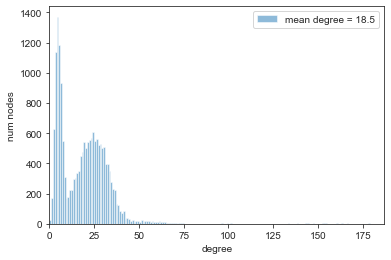

In [5]:
# Degrees without food queue, just neighbors
min_G, max_G = min_degree(graph), max_degree(graph)
print("Min degree:", min_G, "Max degree:", max_G)
plot_degree_distn(graph, max_degree=max_G)

Min degree: 0 Max degree: 197


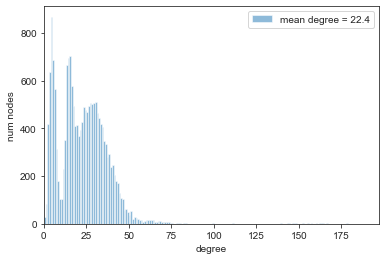

In [6]:
# Degrees with 1 food queue
min_G, max_G = min_degree(graph_1fq), max_degree(graph_1fq)
print("Min degree:", min_G, "Max degree:", max_G)
plot_degree_distn(graph_1fq, max_degree=max_G)

### 3) Create node groups of 10 year age bucket to track the results

In [7]:
node_groups=create_node_groups(graph)

### 4) Define SEIRS model parameters

In [8]:
transmission_rate = 1.28
progression_rate = round(1/5.1, 3)
recovery_rate = 0.056 # Approx 1/18 -> Recovery occurs after 18 days
hosp_rate = round(1/11.4, 3) #1/6.3 # From Tucker Model
# crit_rate = 0.3 # From camp_params
crit_rate = list((sample_pop["death_rate"] / sample_pop["prob_symptomatic"]) / sample_pop["prob_hospitalisation"])
death_rate = 0.75

prob_global_contact = 1
prob_detected_global_contact = 1

# prob_hosp_to_critical = list(sample_pop["death_rate"]/sample_pop["prob_hospitalisation"])
prob_death = list(sample_pop["death_rate"])
prob_asymptomatic = list(1 - sample_pop["prob_symptomatic"])
prob_symp_to_hosp = list(sample_pop["prob_hospitalisation"])

init_symp_cases = 1
init_asymp_cases = 0

### 5) Running the base model

In [9]:
# Model construction
ref_model = SymptomaticSEIRSNetworkModel(G=graph_1fq, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, 
                                         lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, p=prob_global_contact, a=prob_asymptomatic, f=death_rate, 
                                         h=prob_symp_to_hosp, q=prob_detected_global_contact, initI_S=init_symp_cases, initI_A=init_asymp_cases, store_Xseries=True)

In [10]:
t_steps = 200
node_states, simulation_results = run_simulation(ref_model, t_steps)

  0%|          | 0/200 [00:00<?, ?it/s]

Running simulation for 200 steps...



100%|██████████| 200/200 [57:29<00:00, 17.25s/it]   


In [11]:
# Model name for storage
fig_name = f"BaseSympModel_HW={household_weight}_NW={neighbor_weight}_FW={food_weight}_TransR={transmission_rate}_RecR={recovery_rate}_ProgR={progression_rate}_HospR={hosp_rate}_CritR={sum(crit_rate)/len(crit_rate)}_DeathR={death_rate}_initI_S={init_symp_cases}_initI_A={init_asymp_cases}_T={t_steps}"

In [12]:
#here we set up a parallel computing to run experiments in parallel and aggregate the results

In [13]:
output_df = results_to_df(simulation_results, store=True, store_name=f"results/{fig_name}.csv")

In [14]:
output_df

,Susceptible,Exposed,Infected_Presymptomatic,Infected_Symptomatic,Infected_Asymptomatic,Hospitalized,Recovered,Fatalities,Detected_Presymptomatic,Detected_Symptomatic,Detected_Asymptomatic,T_index,Time
0,18696.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1
1,18695.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2
2,18694.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6,3
3,18694.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7,4
4,18693.0,5.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,18048.0,652.0,0.0,0.0,0.0,75476,196
196,0.0,0.0,0.0,0.0,0.0,0.0,18048.0,652.0,0.0,0.0,0.0,75476,197
197,0.0,0.0,0.0,0.0,0.0,0.0,18048.0,652.0,0.0,0.0,0.0,75476,198
198,0.0,0.0,0.0,0.0,0.0,0.0,18048.0,652.0,0.0,0.0,0.0,75476,199


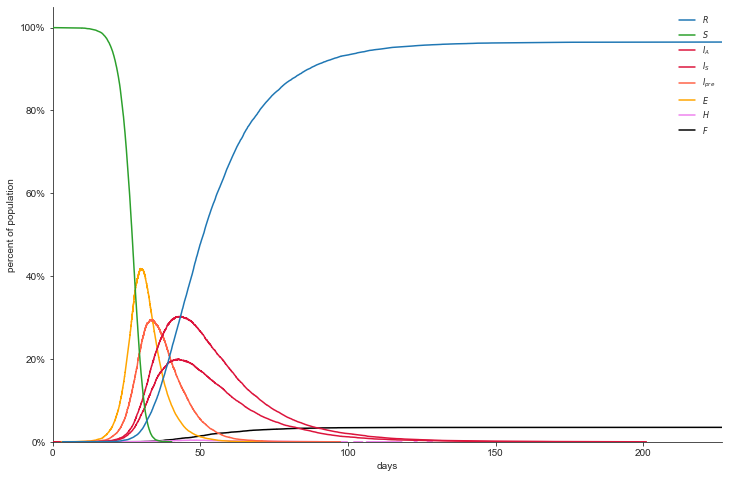

In [15]:
fig, ax = ref_model.figure_basic()#vlines=interventions.get_checkpoints()['t'])
fig.savefig(f"plots/{fig_name}_figBasic.png")

### 6) Define Interventions

With the interventions module, we can create an intervention with just a time step and a custom network referring to that intervention, as well as remove/edit them from the list. The method get_checkpoints() will allow us to get the dictionary to be fed to the SEIRS+ model

#### 6.1) First, define the intervention graphs

In [16]:
# This is social distancing within the food queue 
distancing_graph = remove_edges_from_graph(graph_1fq, scale=10, edge_label_list=["food"], min_num_edges=4)

# This also includes neighbor/friendship edges
quarantine_graph = remove_edges_from_graph(graph_1fq, scale=2, edge_label_list=["food", "friendship"], min_num_edges=2)

# Create graphs with multiple sectoring of food queues - in this case, 1 and 2 queues per each block (4 and 8 food queues respectively)
graph_4fq = create_multiple_food_queues(graph, 1, food_weight, nodes_per_struct, [grid_isoboxes, grid_block1, grid_block2, grid_block3])
graph_8fq = create_multiple_food_queues(graph, 2, food_weight, nodes_per_struct, [grid_isoboxes, grid_block1, grid_block2, grid_block3])

# Create quarantine graphs for the sectored graphs
quarantine_graph_4fq = remove_edges_from_graph(graph_4fq, scale=2, edge_label_list=[f"food_{i}" for i in range(4)] + ["friendship"], min_num_edges=2)
quarantine_graph_8fq = remove_edges_from_graph(graph_8fq, scale=2, edge_label_list=[f"food_{i}" for i in range(8)] + ["friendship"], min_num_edges=2)

Min degree: 0 Max degree: 189


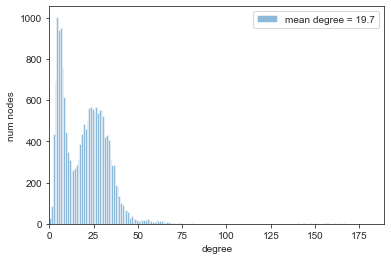

In [17]:
min_D, max_D = min_degree(distancing_graph), max_degree(distancing_graph)
print("Min degree:", min_D, "Max degree:", max_D)

# As we can see, there isn't much of a difference when we only cut food-queue interactions, 
# which means we need a harder distancing policy
plot_degree_distn(distancing_graph, max_degree=max_D)

Min degree: 0 Max degree: 18


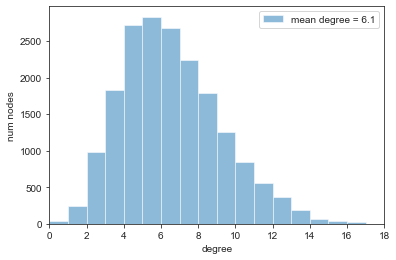

In [18]:
min_Q, max_Q = min_degree(quarantine_graph), max_degree(quarantine_graph)
print("Min degree:", min_Q, "Max degree:", max_Q)

plot_degree_distn(quarantine_graph, max_degree=max_Q)

Min degree: 0 Max degree: 190


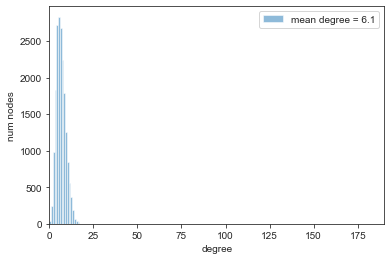

In [19]:
# 4 food queues 
min_4fq, max_4fq = min_degree(graph_4fq), max_degree(graph_4fq)
print("Min degree:", min_4fq, "Max degree:", max_4fq)

plot_degree_distn(quarantine_graph, max_degree=max_4fq)

Min degree: 0 Max degree: 187


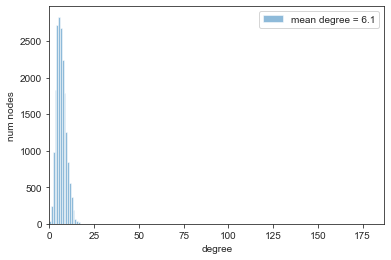

In [20]:
# 8 food queues
min_8fq, max_8fq = min_degree(graph_8fq), max_degree(graph_8fq)
print("Min degree:", min_8fq, "Max degree:", max_8fq)

plot_degree_distn(quarantine_graph, max_degree=max_8fq)

#### 6.2) Construct the checkpoints

In [21]:
interventions = Interventions()
reduction_percentage = 0.5

# Simulate quarantine + masks
interventions.add(quarantine_graph, 3, beta=transmission_rate*reduction_percentage)

# Simulate HALT of quarantine but people still have to wear masks
interventions.add(graph_1fq, 63, beta=transmission_rate*reduction_percentage)

# Simulate HALT of wearing masks
interventions.add(graph_1fq, 93, beta=transmission_rate)

checkpoints = interventions.get_checkpoints()

### 7) Running the model with interventions

In [22]:
# Model construction with interventions on the model with 1 food queue
interventions_model = SymptomaticSEIRSNetworkModel(G=graph_1fq, Q=quarantine_graph, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, 
                                         lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, p=prob_global_contact, a=prob_asymptomatic, f=death_rate, 
                                         h=prob_symp_to_hosp, q=prob_detected_global_contact, initI_S=init_symp_cases, initI_A=init_asymp_cases, store_Xseries=True)

In [23]:
t_steps = 200
intervention_node_states, intervention_results = run_simulation(interventions_model, t_steps, checkpoints)

  0%|          | 0/200 [00:00<?, ?it/s]

Running simulation for 200 steps...



100%|██████████| 200/200 [30:25<00:00,  9.13s/it]  


In [24]:
# Model name for storage - adjust accordingly to interventions
mean_degree = round(sum([degree for node, degree in quarantine_graph.degree])/len(quarantine_graph.degree), 3) # Get the mean degree
quarantine_duration = "3-63"

fig_name = f"InterventionsSympModel_HW={household_weight}_NW={neighbor_weight}_FW={food_weight}_TransR={transmission_rate}_RecR={recovery_rate}_ProgR={progression_rate}_HospR={hosp_rate}_CritRate={sum(crit_rate)/len(crit_rate)}_DeathR={death_rate}_initI_S={init_symp_cases}_initI_A={init_asymp_cases}_T={t_steps}_QDeg={mean_degree}_QDur={quarantine_duration}"

In [25]:
output_df = results_to_df(intervention_results, store=True, store_name=f"results/{fig_name}.csv")

In [26]:
output_df

,Susceptible,Exposed,Infected_Presymptomatic,Infected_Symptomatic,Infected_Asymptomatic,Hospitalized,Recovered,Fatalities,Detected_Presymptomatic,Detected_Symptomatic,Detected_Asymptomatic,T_index,Time
0,18698.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1
1,18697.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
2,18695.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,3
3,18694.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8,4
4,18690.0,7.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,18012.0,688.0,0.0,0.0,0.0,75518,196
196,0.0,0.0,0.0,0.0,0.0,0.0,18012.0,688.0,0.0,0.0,0.0,75518,197
197,0.0,0.0,0.0,0.0,0.0,0.0,18012.0,688.0,0.0,0.0,0.0,75518,198
198,0.0,0.0,0.0,0.0,0.0,0.0,18012.0,688.0,0.0,0.0,0.0,75518,199


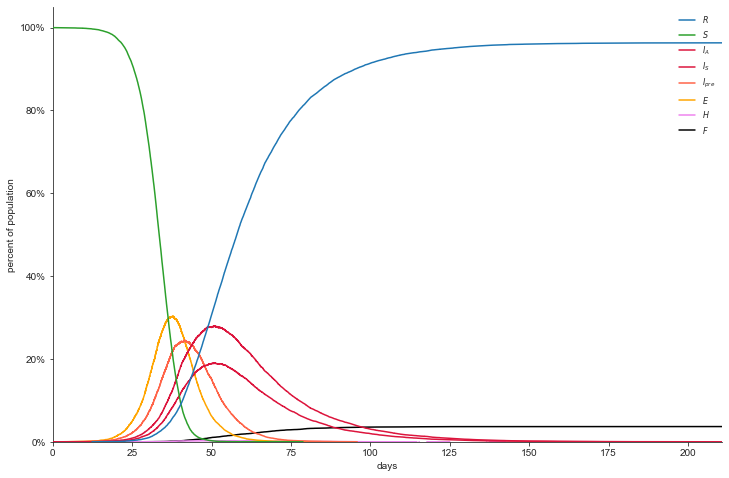

In [27]:
fig, ax = interventions_model.figure_basic()#vlines=interventions.get_checkpoints()['t'])
fig.savefig(f"plots/{fig_name}_figBasic.png")

#### 7.1) Running the base model with multiple food queues

In [28]:
# Model construction for multiple food queues but no more interventions
model_4fq = SymptomaticSEIRSNetworkModel(G=graph_4fq, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, 
                                         lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, p=prob_global_contact, a=prob_asymptomatic, f=death_rate, 
                                         h=prob_symp_to_hosp, q=prob_detected_global_contact, initI_S=init_symp_cases, initI_A=init_asymp_cases, store_Xseries=True)

model_8fq = SymptomaticSEIRSNetworkModel(G=graph_8fq, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, 
                                         lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, p=prob_global_contact, a=prob_asymptomatic, f=death_rate, 
                                         h=prob_symp_to_hosp, q=prob_detected_global_contact, initI_S=init_symp_cases, initI_A=init_asymp_cases, store_Xseries=True)

In [29]:
t_steps = 200
node_states, simulation_results_4fq = run_simulation(model_4fq, t_steps)

  0%|          | 0/200 [00:00<?, ?it/s]

Running simulation for 200 steps...



100%|██████████| 200/200 [22:35<00:00,  6.78s/it] 


In [30]:
# Model name for storage
fig_name = f"SympModel_4FQ_HW={household_weight}_NW={neighbor_weight}_FW={food_weight}_TransR={transmission_rate}_RecR={recovery_rate}_ProgR={progression_rate}_HospR={hosp_rate}_CritR={sum(crit_rate)/len(crit_rate)}_DeathR={death_rate}_initI_S={init_symp_cases}_initI_A={init_asymp_cases}_T={t_steps}"

In [31]:
output_df = results_to_df(simulation_results_4fq, store=True, store_name=f"results/{fig_name}.csv")

In [32]:
output_df

,Susceptible,Exposed,Infected_Presymptomatic,Infected_Symptomatic,Infected_Asymptomatic,Hospitalized,Recovered,Fatalities,Detected_Presymptomatic,Detected_Symptomatic,Detected_Asymptomatic,T_index,Time
0,18697.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1
1,18696.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
2,18694.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,3
3,18693.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,4
4,18688.0,8.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,18057.0,643.0,0.0,0.0,0.0,75466,196
196,0.0,0.0,0.0,0.0,0.0,0.0,18057.0,643.0,0.0,0.0,0.0,75466,197
197,0.0,0.0,0.0,0.0,0.0,0.0,18057.0,643.0,0.0,0.0,0.0,75466,198
198,0.0,0.0,0.0,0.0,0.0,0.0,18057.0,643.0,0.0,0.0,0.0,75466,199


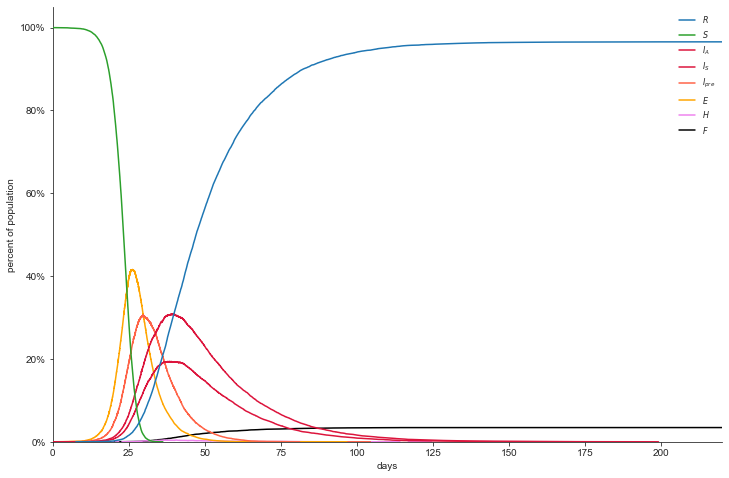

In [33]:
fig, ax = model_4fq.figure_basic()#vlines=interventions.get_checkpoints()['t'])
fig.savefig(f"plots/{fig_name}_figBasic.png")

In [35]:
t_steps = 200
node_states, simulation_results_8fq = run_simulation(model_8fq, t_steps)

  0%|          | 0/200 [00:00<?, ?it/s]

Running simulation for 200 steps...



100%|██████████| 200/200 [33:14<00:00,  9.97s/it]   


In [36]:
# Model name for storage
fig_name = f"SympModel_8FQ_HW={household_weight}_NW={neighbor_weight}_FW={food_weight}_TransR={transmission_rate}_RecR={recovery_rate}_ProgR={progression_rate}_HospR={hosp_rate}_CritR={sum(crit_rate)/len(crit_rate)}_DeathR={death_rate}_initI_S={init_symp_cases}_initI_A={init_asymp_cases}_T={t_steps}"

In [37]:
output_df = results_to_df(simulation_results_8fq, store=True, store_name=f"results/{fig_name}.csv")

In [38]:
output_df

,Susceptible,Exposed,Infected_Presymptomatic,Infected_Symptomatic,Infected_Asymptomatic,Hospitalized,Recovered,Fatalities,Detected_Presymptomatic,Detected_Symptomatic,Detected_Asymptomatic,T_index,Time
0,18696.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1
1,18694.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,2
2,18693.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,3
3,18690.0,5.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13,4
4,18683.0,12.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,18024.0,676.0,0.0,0.0,0.0,75500,196
196,0.0,0.0,0.0,0.0,0.0,0.0,18024.0,676.0,0.0,0.0,0.0,75500,197
197,0.0,0.0,0.0,0.0,0.0,0.0,18024.0,676.0,0.0,0.0,0.0,75500,198
198,0.0,0.0,0.0,0.0,0.0,0.0,18024.0,676.0,0.0,0.0,0.0,75500,199


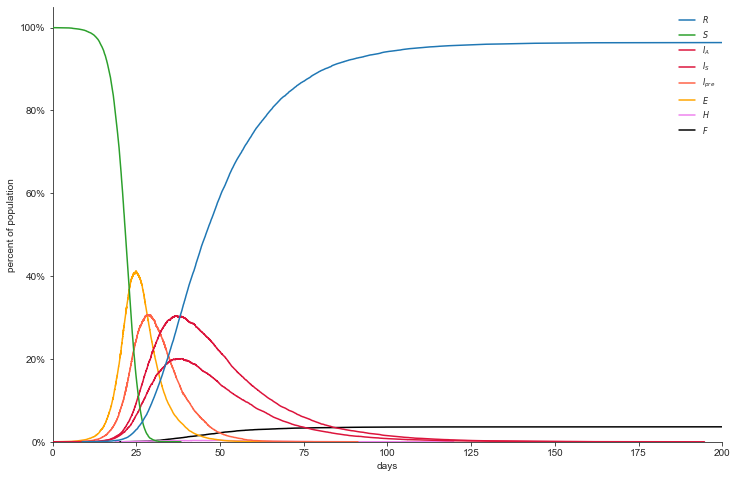

In [39]:
fig, ax = model_8fq.figure_basic()#vlines=interventions.get_checkpoints()['t'])
fig.savefig(f"plots/{fig_name}_figBasic.png")

#### 7.2) Running the multiple food queues model with interventions

In [41]:
# Model construction for multiple food queues in addition to other interventions
interventions_model_4fq = SymptomaticSEIRSNetworkModel(G=graph_4fq, Q=quarantine_graph_4fq, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, 
                                         lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, p=prob_global_contact, a=prob_asymptomatic, f=death_rate, 
                                         h=prob_symp_to_hosp, q=prob_detected_global_contact, initI_S=init_symp_cases, initI_A=init_asymp_cases, store_Xseries=True)

interventions_model_8fq = SymptomaticSEIRSNetworkModel(G=graph_8fq, Q=quarantine_graph_8fq, beta=transmission_rate, sigma=progression_rate, gamma=recovery_rate, 
                                         lamda=progression_rate, mu_H=crit_rate, eta=hosp_rate, p=prob_global_contact, a=prob_asymptomatic, f=death_rate, 
                                         h=prob_symp_to_hosp, q=prob_detected_global_contact, initI_S=init_symp_cases, initI_A=init_asymp_cases, store_Xseries=True)

In [42]:
## Interventions for graph with 4 food queues 
interventions.clear()

# Simulate quarantine + masks
interventions.add(quarantine_graph_4fq, 3, beta=transmission_rate*reduction_percentage)

# Simulate HALT of quarantine but people still have to wear masks
interventions.add(graph_4fq, 63, beta=transmission_rate*reduction_percentage)

# Simulate HALT of wearing masks
interventions.add(graph_4fq, 93, beta=transmission_rate)

checkpoints = interventions.get_checkpoints()

In [57]:
t_steps = 200
node_states, intervention_results_4fq = run_simulation(interventions_model_4fq, t_steps)

  0%|          | 0/200 [00:00<?, ?it/s]

Running simulation for 200 steps...



100%|██████████| 200/200 [26:54<00:00,  8.07s/it]  


In [58]:
# Model name for storage - adjust accordingly to interventions
mean_degree = round(sum([degree for node, degree in quarantine_graph_4fq.degree])/len(quarantine_graph_4fq.degree), 3) # Get the mean degree
quarantine_duration = "3-63"

fig_name = f"InterventionsSympModel4FQ_HW={household_weight}_NW={neighbor_weight}_FW={food_weight}_TransR={transmission_rate}_RecR={recovery_rate}_ProgR={progression_rate}_HospR={hosp_rate}_CritRate={sum(crit_rate)/len(crit_rate)}_DeathR={death_rate}_initI_S={init_symp_cases}_initI_A={init_asymp_cases}_T={t_steps}_QDeg={mean_degree}_QDur={quarantine_duration}"

In [59]:
output_df = results_to_df(intervention_results_4fq, store=True, store_name=f"results/{fig_name}.csv")

In [60]:
output_df

,Susceptible,Exposed,Infected_Presymptomatic,Infected_Symptomatic,Infected_Asymptomatic,Hospitalized,Recovered,Fatalities,Detected_Presymptomatic,Detected_Symptomatic,Detected_Asymptomatic,T_index,Time
0,18698.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,18697.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
2,18696.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
3,18696.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4
4,18696.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,18094.0,606.0,0.0,0.0,0.0,75435,196
196,0.0,0.0,0.0,0.0,0.0,0.0,18094.0,606.0,0.0,0.0,0.0,75435,197
197,0.0,0.0,0.0,0.0,0.0,0.0,18094.0,606.0,0.0,0.0,0.0,75435,198
198,0.0,0.0,0.0,0.0,0.0,0.0,18094.0,606.0,0.0,0.0,0.0,75435,199


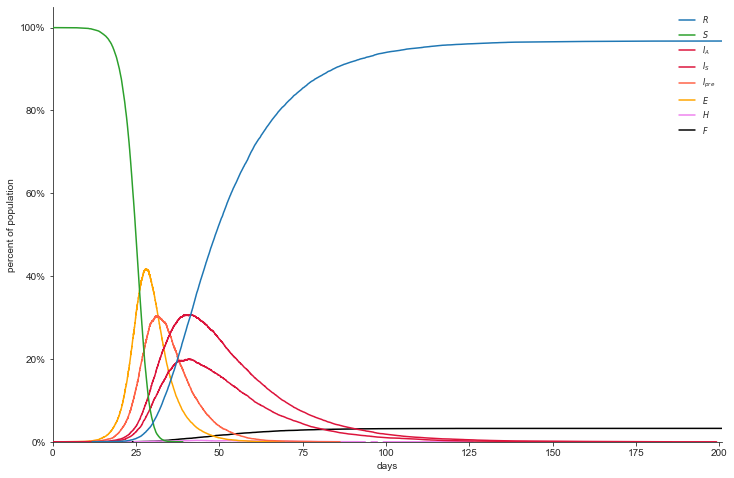

In [61]:
fig, ax = interventions_model_4fq.figure_basic()#vlines=interventions.get_checkpoints()['t'])
fig.savefig(f"plots/{fig_name}_figBasic.png")

In [62]:
## Interventions for graph with 8 food queues 
interventions.clear()

# Simulate quarantine + masks
interventions.add(quarantine_graph_8fq, 3, beta=transmission_rate*reduction_percentage)

# Simulate HALT of quarantine but people still have to wear masks
interventions.add(graph_8fq, 63, beta=transmission_rate*reduction_percentage)

# Simulate HALT of wearing masks
interventions.add(graph_8fq, 93, beta=transmission_rate)

checkpoints = interventions.get_checkpoints()

In [63]:
t_steps = 200
node_states, interventions_results_8fq = run_simulation(interventions_model_8fq, t_steps)

  0%|          | 0/200 [00:00<?, ?it/s]

Running simulation for 200 steps...



100%|██████████| 200/200 [1:18:36<00:00, 23.58s/it]   


In [64]:
# Model name for storage - adjust accordingly to interventions
mean_degree = round(sum([degree for node, degree in quarantine_graph_8fq.degree])/len(quarantine_graph_8fq.degree), 3) # Get the mean degree
quarantine_duration = "3-63"

fig_name = f"InterventionsSympModel8FQ_HW={household_weight}_NW={neighbor_weight}_FW={food_weight}_TransR={transmission_rate}_RecR={recovery_rate}_ProgR={progression_rate}_HospR={hosp_rate}_CritRate={sum(crit_rate)/len(crit_rate)}_DeathR={death_rate}_initI_S={init_symp_cases}_initI_A={init_asymp_cases}_T={t_steps}_QDeg={mean_degree}_QDur={quarantine_duration}"

In [66]:
output_df = results_to_df(interventions_results_8fq, store=True, store_name=f"results/{fig_name}.csv")

In [67]:
output_df

,Susceptible,Exposed,Infected_Presymptomatic,Infected_Symptomatic,Infected_Asymptomatic,Hospitalized,Recovered,Fatalities,Detected_Presymptomatic,Detected_Symptomatic,Detected_Asymptomatic,T_index,Time
0,18697.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1
1,18694.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,2
2,18692.0,5.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,3
3,18686.0,9.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,19,4
4,18683.0,11.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,23,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,18058.0,642.0,0.0,0.0,0.0,75470,196
196,0.0,0.0,0.0,0.0,0.0,0.0,18058.0,642.0,0.0,0.0,0.0,75470,197
197,0.0,0.0,0.0,0.0,0.0,0.0,18058.0,642.0,0.0,0.0,0.0,75470,198
198,0.0,0.0,0.0,0.0,0.0,0.0,18058.0,642.0,0.0,0.0,0.0,75470,199


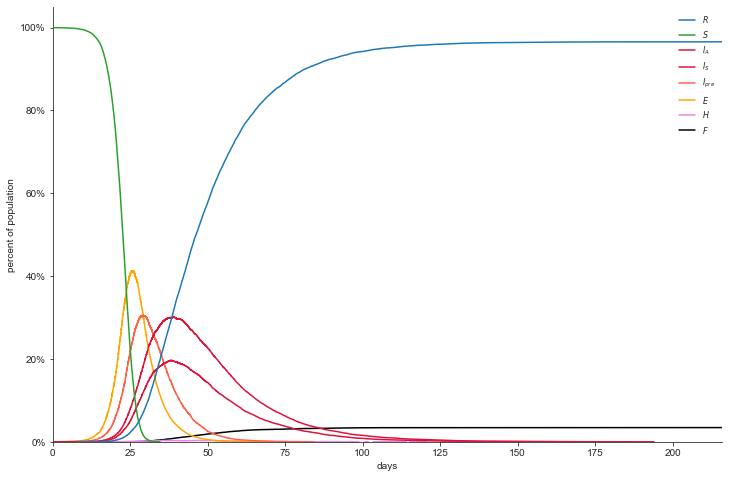

In [68]:
fig, ax = interventions_model_8fq.figure_basic()#vlines=interventions.get_checkpoints()['t'])
fig.savefig(f"plots/{fig_name}_figBasic.png")